# 年別

In [ ]:
import pandas as pd
import numpy as np
import re
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import product
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
#plt.style.use('seaborn-pastel')
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tq

sys.path.append("..")
from utils.util_functions import *

pd.set_option('display.max_rows', 500)

In [2]:
#event_df = make_df(data_dir=DETAIL_DATA_DIR_MLB)
#event_df = pd.read_csv(os.path.join(ROOT_DIR, "event_df.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2017 = make_df(end=1944417, data_dir=DETAIL_DATA_DIR_MLB)
#df_2017 = pd.read_csv(os.path.join(ROOT_DIR, "df_2017.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2018 = make_df(start=1944417, data_dir=DETAIL_DATA_DIR_MLB)
#df_2018 = pd.read_csv(os.path.join(ROOT_DIR, "df_2018.csv"), index_col=0, encoding="cp932", dtype=object)
files = os.listdir(DETAIL_DATA_DIR_MLB)[1:]
names = pd.Series(files).apply(lambda x: int(x.split(".")[0]))
files_2017 = names[names<=1944417].apply(lambda x: str(x)+".csv")
files_2018 = names[names>1944417].apply(lambda x: str(x)+".csv")
column = "得点"
teams_mlb = list(set(pd.read_csv(os.path.join(SCORE_DATA_DIR_MLB, "score_mlb.csv"), encoding="cp932", index_col=0).表チーム))
teams_mlb.remove("ア・リーグ")
first_teams = ['Rソックス', 'インディアンス', 'アストロズ', 'ブレーブス', 'ブリュワーズ', 'ドジャース']
second_teams = ['ヤンキース', 'ツインズ', 'アスレチックス', 'ナショナルズ', 'カブス', 'ロッキーズ']
third_teams = ['レイズ', 'タイガース', 'マリナーズ', 'フィリーズ', 'カージナルス', 'Dバックス']
fourth_teams = ['ブルージェイズ', 'Wソックス',  'エンゼルス', 'メッツ', 'パイレーツ', 'ジャイアンツ']
fifth_teams = ['オリオールズ', 'ロイヤルズ', 'レンジャーズ', 'マーリンズ', 'レッズ', 'パドレス']

In [3]:
def ranking(team):
    first_teams = ['Rソックス', 'インディアンス', 'アストロズ', 'ブレーブス', 'ブリュワーズ', 'ドジャース']
    second_teams = ['ヤンキース', 'ツインズ', 'アスレチックス', 'ナショナルズ', 'カブス', 'ロッキーズ']
    third_teams = ['レイズ', 'タイガース', 'マリナーズ', 'フィリーズ', 'カージナルス', 'Dバックス']
    fourth_teams = ['ブルージェイズ', 'Wソックス',  'エンゼルス', 'メッツ', 'パイレーツ', 'ジャイアンツ']
    fifth_teams = ['オリオールズ', 'ロイヤルズ', 'レンジャーズ', 'マーリンズ', 'レッズ', 'パドレス']
    lst = [first_teams, second_teams, third_teams, fourth_teams, fifth_teams]
    for i in range(len(lst)):
        teams = lst[i]
        if team in teams:
            return i + 1

In [4]:
case_expected_score_dict = dict(pd.read_csv(os.path.join(ROOT_DIR, "case_expected_score.csv"), dtype=object).values)
case_expected_score_dict = dict([[key, float(value)] for key, value in case_expected_score_dict.items()])

def weighted_score(case, score):
    """
    lst : (Stの状況, 直後の得点)
    """
    return score / case_expected_score_dict[case]

In [5]:
team = "Rソックス"
"""df = event_df[event_df.攻撃チーム==team]
triple = make_inning_triple(make_inning_list(df, score_end=1, how="both"))
lst = make_flattened_list(triple)"""

'df = event_df[event_df.攻撃チーム==team]\ntriple = make_inning_triple(make_inning_list(df, score_end=1, how="both"))\nlst = make_flattened_list(triple)'

In [ ]:
def triple_on_score_diff(team, diff_lower, diff_upper, year="both"):
    if year == "both":
        df = event_df[event_df.攻撃チーム==team]
    elif int(year) == 2018:
        df = df_2018[df_2018.攻撃チーム==team]
    elif int(year) == 2017:
        df = df_2017[df_2017.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=1, how="both"))
    lst = make_flattened_list(triple)
    res = []
    for elem in lst:
        my_score = int(elem[1][1])
        opp_score = int(elem[1][2])
        if diff_lower < diff_upper:
            if diff_lower <= my_score - opp_score <= diff_upper:
                res.append(((elem[0][0], elem[0][1]), (elem[1][0], elem[1][1]), (elem[2][0], elem[2][1])))
        elif diff_lower > diff_upper:
            if diff_lower <= my_score - opp_score or my_score - opp_score <= diff_upper:
                res.append(((elem[0][0], elem[0][1]), (elem[1][0], elem[1][1]), (elem[2][0], elem[2][1])))
        else:
            raise "diff_lower == diff_upper"
    return res

## positive inhibition = 勝ってるから気をぬく = 流れはいいのに点が取れない

## positive inhibitionを起こしがちなチームは、大差がつくとimp時の期待得点が下がる

# 点数気にしない

In [6]:
#imp_list = []
#det_list = []
res_dict1 = dict()
for team in teams_mlb:
    df = df_2017[df_2017.攻撃チーム==team]
    triple = make_inning_triple(make_inning_list(df, score_end=1, how="own"))
    lst = make_flattened_list(triple[:])
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    #imp_list.append(np.mean(improved_score_list))
    #det_list.append(np.mean(deteriorated_score_list))
    res_dict1[team] = (np.mean(improved_score_list), np.mean(deteriorated_score_list))
    print(team, np.mean(improved_score_list), np.mean(deteriorated_score_list))

ツインズ 0.92366038901 0.789537944542
ブリュワーズ 1.08518435977 1.0108727633
マリナーズ 0.972623184145 0.952930514751
Rソックス 0.835660697013 0.690565289127
ドジャース 0.905195114327 1.00288118137
ロイヤルズ 1.12085736287 0.848346455636
インディアンス 0.902157628414 1.04603281857
マーリンズ 1.02208802284 0.899243691333
エンゼルス 0.915604275109 0.801461744543
ロッキーズ 0.921682757292 0.838801280813
ジャイアンツ 0.627556698516 0.762969569229
オリオールズ 1.0871926731 0.984524869702
Wソックス 0.986304445102 0.842205430476
ブルージェイズ 1.01799941371 0.931078816168
レンジャーズ 0.994612886939 1.04599630139
ブレーブス 0.862033886908 0.769437199549
タイガース 0.986390570936 0.84013737406
カージナルス 0.888277676248 0.943655405455
カブス 0.952157860171 1.05752610441
レイズ 0.852290644196 1.04489940481
レッズ 0.903544618683 0.934222023326
ナショナルズ 1.01105943324 0.7801661568
パドレス 0.814943206198 0.867884050255
アストロズ 0.9132393372 0.855633951329
Dバックス 1.14028315707 0.933797819461
メッツ 0.876622210086 1.0933786905
フィリーズ 0.92729822789 0.7691952027
パイレーツ 0.84943231764 0.552902308153
ヤンキース 1.02982089689

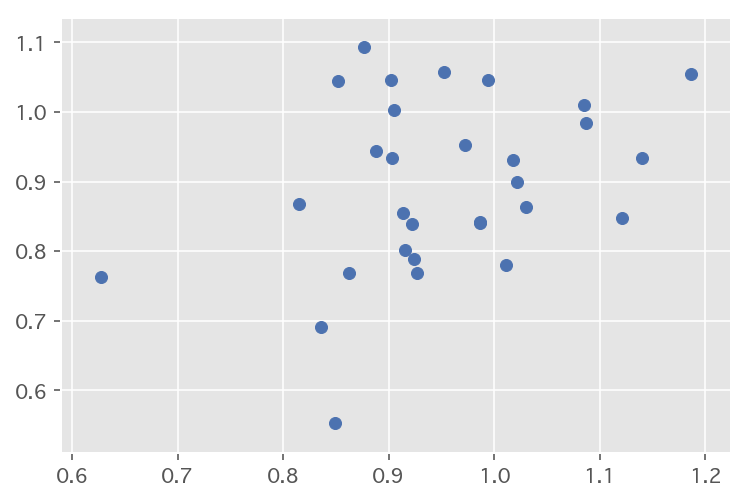

In [7]:
plt.scatter([elem[0] for elem in list(res_dict1.values())], [elem[1] for elem in list(res_dict1.values())])

# n点差以上

In [8]:
#imp_list = []
#det_list = []
res_dict = dict()
for team in teams_mlb:
    lst = triple_on_score_diff(team, 5, 30, 2017)
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    #imp_list.append(np.mean(improved_score_list))
    #det_list.append(np.mean(deteriorated_score_list))
    res_dict[team] = (np.mean(improved_score_list), np.mean(deteriorated_score_list))
    print(team, np.mean(improved_score_list), np.mean(deteriorated_score_list))

ツインズ 1.02429217415 1.09577853495
ブリュワーズ 1.17004138477 0.217108418709
マリナーズ 1.07340088741 1.71716082127
Rソックス 0.82304789357 0.267296633213
ドジャース 1.09514342641 0.972404516893
ロイヤルズ 0.903684219314 0.501407611255
インディアンス 0.690508116986 0.93580347966
マーリンズ 0.844700586467 0.609220822057
エンゼルス 1.04109186989 0.609635918008
ロッキーズ 1.13315253832 1.06076028418
ジャイアンツ 0.518101596835 0.936915425716
オリオールズ 0.983023142603 0.704857922714
Wソックス 1.15116563166 0.989233106523
ブルージェイズ 0.661647094488 0.322717581665
レンジャーズ 0.771230700529 1.0405860491
ブレーブス 0.860737288635 0.673174586152
タイガース 1.06562119268 0.625187672352
カージナルス 0.86756518998 0.949239711033
カブス 1.36654259823 1.08943217923
レイズ 1.29664770187 1.27247288319
レッズ 0.679588122316 1.3185808625
ナショナルズ 1.55832391772 0.421192148936
パドレス 0.54041243309 0.0
アストロズ 1.037989045 0.891905868463
Dバックス 1.58739495139 0.569162659891
メッツ 0.769830937235 1.30224353486
フィリーズ 1.1692607538 1.24186725232
パイレーツ 1.60216341893 1.01228898133
ヤンキース 1.35696747384 0.783368408179
アス

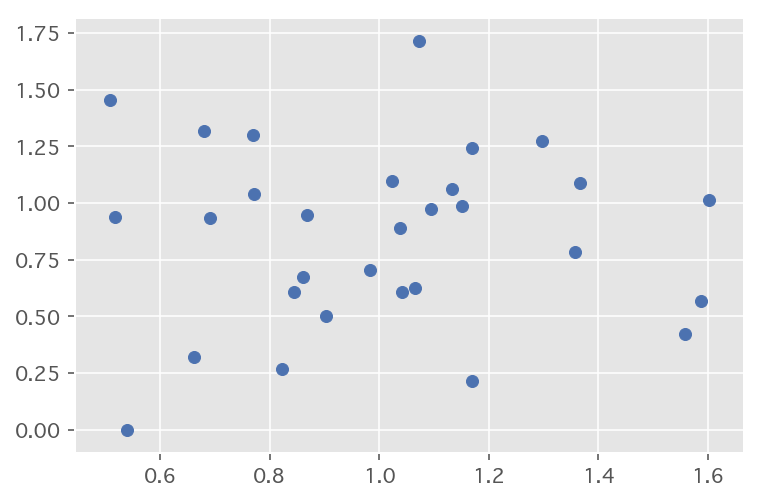

In [9]:
plt.scatter([elem[0] for elem in list(res_dict.values())], [elem[1] for elem in list(res_dict.values())])

In [10]:
# 大差で勝っていると流れがいいとボコボコにするチーム
for team in teams_mlb:
    if res_dict1[team][0] < res_dict[team][0]:
        print(ranking(team), team, res_dict[team][0] - res_dict1[team][0])

2 ツインズ 0.100631785139
1 ブリュワーズ 0.0848570249992
3 マリナーズ 0.100777703266
1 ドジャース 0.189948312083
4 エンゼルス 0.125487594776
2 ロッキーズ 0.21146978103
4 Wソックス 0.164861186559
3 タイガース 0.0792306217425
2 カブス 0.414384738062
3 レイズ 0.444357057672
2 ナショナルズ 0.547264484474
1 アストロズ 0.124749707796
3 Dバックス 0.447111794317
3 フィリーズ 0.241962525912
4 パイレーツ 0.752731101293
2 ヤンキース 0.327146576949


In [11]:
# 大差で勝っていると油断するチーム
for team in teams_mlb:
    if res_dict1[team][0] > res_dict[team][0]:
        print(ranking(team), team, res_dict[team][0] - res_dict1[team][0])

1 Rソックス -0.0126128034437
5 ロイヤルズ -0.217173143554
1 インディアンス -0.211649511428
5 マーリンズ -0.177387436371
4 ジャイアンツ -0.109455101681
5 オリオールズ -0.104169530501
4 ブルージェイズ -0.356352319221
5 レンジャーズ -0.22338218641
1 ブレーブス -0.00129659827288
3 カージナルス -0.0207124862683
5 レッズ -0.223956496368
5 パドレス -0.274530773108
4 メッツ -0.106791272851
2 アスレチックス -0.677954494503
